In [1]:
from grape.utils import DataSet
data = DataSet(file_path='/Users/faerte/Desktop/grape/notebooks/data/processed/BradleyDoublePlus.pickle')
train, test, val = data.get_splits()

from grape.models import MGConv, SimpleGNN
import torch

node_hidden_dim = 64
batch_size = 32

model_message = MGConv(num_layers=5, edge_hidden_dim=64, node_hidden_dim=node_hidden_dim, 
                node_in_dim=data.num_node_features, edge_in_dim=data.num_edge_features)

model = SimpleGNN(model_message=model_message,
                      input_pool_size=node_hidden_dim, 
                      output_size=1)

device = torch.device('cpu')

from torch import nn

loss_func = nn.functional.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

from grape.utils import train_model

train_loss, val_loss = train_model(model = model,
                                   loss_func = loss_func,
                                   optimizer = optimizer,
                                   train_data_loader= train,
                                   val_data_loader = val,
                                   batch_size=batch_size,
                                   epochs=1,
                                   early_stopping=True,
                                   patience=20)

from grape.utils import test_model
test_model(model = model,
           test_data_loader= test,
           loss_func= loss_func);


from grape.utils import pred_metric
from grape.utils import SubSet, torch_subset_to_SubSet
import numpy as np

# Generate predictions (we save the latents for later)
preds, lats = test_model(model=model,
                   test_data_loader=test,
                   loss_func=None)

test = torch_subset_to_SubSet(test)

lats = lats.cpu().detach().numpy()

pred_metric(preds, test.y)

Loaded dataset.


epoch=0, training loss= 0.802, validation loss= 0.636: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]
100%|██████████| 10/10 [00:00<00:00, 212.33it/s]


Test loss: 0.712


100%|██████████| 10/10 [00:00<00:00, 206.12it/s]


{'mse': 0.725608113941884}

In [2]:
from sklearn.decomposition import PCA
model_pca = PCA(n_components=2)
model_pca.fit(lats)

V = model_pca.components_.T
print(V.shape)
print(lats.shape)
projection = lats@V
print(projection.shape)

(64, 2)
(299, 64)
(299, 2)


In [3]:
from grape.utils import classyfire, classyfire_result_analysis
ids = classyfire(test.smiles[:10])
mols_class, _ = classyfire_result_analysis()

Found log file in working directory.
Loaded existing log_file. Here is the data head:
  filename                                             smiles
0   0.json                                           CC(C)CCO
1   1.json                                 COC(=O)c1ccc(I)cc1
2   3.json                                              C=CCN
3   0.json                                   N#Cc1ccc(C#N)cc1
4   1.json  Clc1c(Cl)c(Cl)c(-c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl)c(...
5   2.json                                CCOC(=O)c1ccc(O)cc1
6   3.json             O=[N+]([O-])c1ccc(Cl)c([N+](=O)[O-])c1
7   4.json                                O=C1CCN(c2ccccc2)N1
8   5.json                                         CC=C(C)CCC
9   6.json                        O=C(O)c1c(F)c(F)c(F)c(F)c1F
Mol 4 in log datafile, so skipping it.
Mol 9 in log datafile, so skipping it.


100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


In [7]:
mols_class, _ = classyfire_result_analysis(idx=ids)
print(mols_class)
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
labels = enc.fit_transform(list(mols_class.values()))
print(labels)

{833: 'Lipids and lipid-like molecules', 1028: 'Hydrocarbons', 0: 'Benzenoids', 1: 'Organoheterocyclic compounds', 2: 'Hydrocarbons', 3: 'Lipids and lipid-like molecules', 5: 'Benzenoids', 6: 'Benzenoids', 7: 'Benzenoids', 8: 'Organic acids and derivatives'}
[2 1 0 4 1 2 0 0 0 3]


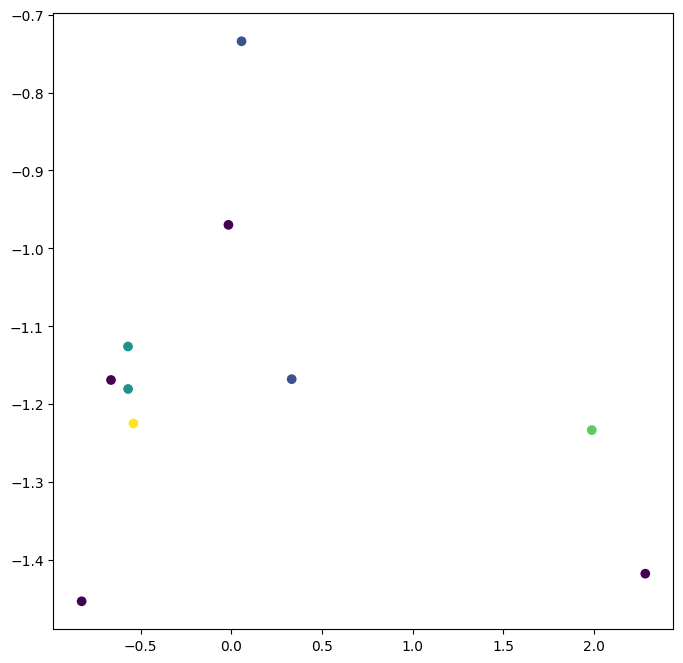

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(projection[:10,0], projection[:10,1], c = labels)


In [ ]:
import os
import pandas as pd

def file_in_dir(directory, filename):
    for root, dirs, files in os.walk(directory):
        if filename in files:
            return True


class classyfire(object):
    """
    
    """
    
    def __init__(self, path_to_export: str = None,
               record_log_file: bool = True, existing_log_file: str = None):
        
        if path_to_export is None:

            path_to_export = os.getcwd() + '/analysis_results'
    
            if not os.path.exists(path_to_export):
                os.mkdir(path_to_export)
    
            if existing_log_file is None:
                if file_in_dir(path_to_export, 'recorded_SMILES.csv'):
                    print('Found log file in working directory.')
                    existing_log_file = os.path.join(path_to_export,'recorded_SMILES.csv')
                    
        if record_log_file and existing_log_file is None:
            self.log_file = os.path.join(path_to_export, 'recorded_SMILES.csv')
            self.log_frame = pd.DataFrame({'filename':[], 'smiles':[]})
        
        elif existing_log_file is not None:
            try:
                self.log_frame = pd.read_csv(existing_log_file)
                log_file = existing_log_file
                print('Loaded existing log_file. Here is the data head:')
                #print(log_frame.head(10))
            except:
                print('Passed log_file is not valid, creating a new one.')
                self.log_file = os.path.join(path_to_export, 'recorded_SMILES.csv')
                self.log_frame = pd.DataFrame({'filename': [], 'smiles': []})
        
    #def retrieve_classyfiles(self):
        


In [1]:
from grape.datasets import BradleyDoublePlus
from grape.utils.data_splitting import taylor_butina_clustering
data = BradleyDoublePlus()

train, val, test = taylor_butina_clustering(data, threshold=0.8, radius=3)

ModuleNotFoundError: No module named 'grape.utils.data_splitting'

In [4]:
print(train[0])

Data(x=[9, 42], edge_index=[2, 18], edge_attr=[18, 12], y=[1])


In [2]:
test = (1,2,3)
for i in test:
    print(i)

1
2
3


In [4]:
def test(x):
    for i in x:
        yield i

test((1,2,3,4))
tuple(item for item in test((1,2,3,4)))

(1, 2, 3, 4)

In [6]:
from grape.datasets import BradleyDoublePlus
from dgllife.utils import splitters
data = BradleyDoublePlus()
import numpy as np

def split_data(data, split_type: str = None, split_frac: float = None, custom_split: list = None,
               labels: np.array = None, task_id: int = None, bucket_size: int = 10, **kwargs) -> tuple:
    """

    Parameters
    ------------
    data: Any iterable
        An object that can be accessed per an index and iterated upon. Ex: a DataSet or array object
    split_type: str
        Indicates what split should be used. Default: random. The options are: ['consecutive', 'random',
        'molecular weight', 'scaffold', 'stratified', 'custom']
    split_frac: list
        Indicates what the split fractions should be. Default: [0.8, 0.1, 0.1]
    custom_split: list
        The custom split that should be applied. Has to be an array matching the length of the filtered smiles,
        where 0 indicates a training sample, 1 a testing sample and 2 a validation sample. Default: None
    labels: array
        An array of shape (N,T) where N is the number of datasets points and T is the number of tasks. Used for the
        Stratified Splitter.
    task_id: int
        The task that will be used for the Stratified Splitter.
    bucket_size: int
        Size of the bucket that is used in the Stratified Splitter. Default: 10


    Returns
    ---------
    (train, val, test)
        - Lists containing the respective datasets objects.

    """

    if split_type is None:
        split_type = 'random'

    if split_frac is None:
        split_frac = [0.8,0.1,0.1]



    split_func = {
        'consecutive': splitters.ConsecutiveSplitter,
        'random': splitters.RandomSplitter,
        'molecular_weight': splitters.MolecularWeightSplitter,
        'scaffold': splitters.ScaffoldSplitter,
        'stratified': splitters.SingleTaskStratifiedSplitter
    }

    if split_type == 'custom' or custom_split is not None:
        assert custom_split is not None and len(custom_split) == len(data), (
            'The custom split has to match the length of the filtered dataset.'
            'Consider saving the filtered output with .get_smiles()')

        return data[custom_split == 0], data[custom_split == 1], data[custom_split == 2]

    match split_type:
        case 'consecutive':
            return split_func[split_type].train_val_test_split(data,frac_train=split_frac[0],frac_test=split_frac[1],
                                                                frac_val=split_frac[2])
        case 'random':
            return split_func[split_type].train_val_test_split(data, frac_train=split_frac[0], frac_test=split_frac[1],
                                                                frac_val=split_frac[2])
        case 'molecular_weight':
            return split_func[split_type].train_val_test_split(data, frac_train=split_frac[0], frac_test=split_frac[1],
                                                               frac_val=split_frac[2], **kwargs)
        case 'scaffold':
            return split_func[split_type].train_val_test_split(data, frac_train=split_frac[0], frac_test=split_frac[1],
                                                    frac_val=split_frac[2], log_every_n=1000, scaffold_func='decompose')
        case 'stratified':
            return split_func[split_type].train_val_test_split(data, labels, task_id, frac_train=split_frac[0],
                                                frac_test=split_frac[1],frac_val=split_frac[2], bucket_size=bucket_size)
        
split_data(data, split_type='molecular_weight', log_every_n = 400)

Start initializing RDKit molecule instances...
Creating RDKit molecule instance 400/2996
Creating RDKit molecule instance 800/2996
Creating RDKit molecule instance 1200/2996
Creating RDKit molecule instance 1600/2996
Creating RDKit molecule instance 2000/2996
Creating RDKit molecule instance 2400/2996
Creating RDKit molecule instance 2800/2996
Start computing molecular weights.
Computing molecular weight for compound 400/2996
Computing molecular weight for compound 800/2996
Computing molecular weight for compound 1200/2996
Computing molecular weight for compound 1600/2996
Computing molecular weight for compound 2000/2996
Computing molecular weight for compound 2400/2996
Computing molecular weight for compound 2800/2996


In [12]:
from grape.datasets import BradleyDoublePlus
from grape.utils import split_data
data = BradleyDoublePlus()
import numpy as np

train, val, test = split_data(data, split_type='butina', threshold=0.6)
print(train)

Number of single molecule clusters: 765 and the ratio is: 0.631 of single molecule clusters.


In [8]:
import numpy as np
test = np.array([1,2,3,4,1,1,2,3])
print(test.index(test==1))

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [10]:
test = np.array([1,2,3,4,1,1,2,3])
test = (test-np.mean(test))/np.std(test)
print(test)
test = (test-np.mean(test))/np.std(test)
print(test)

[-1.06810349 -0.11867817  0.83074716  1.78017249 -1.06810349 -1.06810349
 -0.11867817  0.83074716]
[-1.06810349 -0.11867817  0.83074716  1.78017249 -1.06810349 -1.06810349
 -0.11867817  0.83074716]


In [3]:
from torch.nn import Module, Sequential
import torch
from grape.models import MPNN
from grape.utils import reset_weights

model = MPNN(64, 64)
print(model)


MPNN(
  (lin_in): Linear(in_features=64, out_features=64, bias=True)
  (gru): GRU(64, 64, num_layers=10)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4096, bias=True)
  )
  (gnn_layers): ModuleList(
    (0-3): 4 x NNConv(64, 64, aggr=add, nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=4096, bias=True)
    ))
  )
)


In [12]:
from torch.nn import Module, Sequential
import torch
from grape.models import MPNN
from grape.utils import reset_weights, reset_model_weights

model = MPNN(64, 64)
for i in model.children():
    print(i)

print(model.mlp.children())
for i in model.mlp.children():
    print(i)
    if hasattr(i, 'reset_parameters'):
        print(i.weight.data)
        i.weight.data = torch.ones(64,64)
        print(i.weight.data)
        
reset_weights(model)
for i in (model.children()):
    for j in i.children():
        print(j)
        if hasattr(j, 'children'):
            for z in j.children():
                if hasattr(z, 'reset_parameters') and hasattr(z, 'weight'):
                    print(z.weight.data)
        elif hasattr(j, 'reset_parameters'):
            print(j.weight.data)
#    print(i)

Linear(in_features=64, out_features=64, bias=True)
GRU(64, 64, num_layers=10)
Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=4096, bias=True)
)
ModuleList(
  (0-3): 4 x NNConv(64, 64, aggr=add, nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4096, bias=True)
  ))
)
<generator object Module.children at 0x30ae38120>
Linear(in_features=64, out_features=64, bias=True)
tensor([[ 0.1021,  0.0348, -0.0363,  ..., -0.0731, -0.0287, -0.0903],
        [ 0.0916, -0.0162,  0.0435,  ..., -0.1165,  0.0802, -0.0188],
        [ 0.0897,  0.0470,  0.0829,  ..., -0.0558,  0.1143, -0.0566],
        ...,
        [-0.0355, -0.0944, -0.1071,  ...,  0.0206, -0.0467, -0.0611],
        [-0.0103,  0.105

In [13]:
print(hasattr(model, 'reset_parameters'))

False


In [5]:
from grape.datasets import BradleyDoublePlus
data = BradleyDoublePlus()

train, val, test = data.get_splits(random_state = 0)

from grape.models import MGConv, SimpleGNN
from torch import nn
import torch

node_hidden_dim = 64
batch_size = 32

model_message = MGConv(num_layers=5, edge_hidden_dim=64, node_hidden_dim=node_hidden_dim, 
                node_in_dim=data.num_node_features, edge_in_dim=data.num_edge_features)

out_model = nn.Sequential(
    nn.Linear(node_hidden_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)


model = SimpleGNN(model_message=model_message,
                  out_model=out_model)
                  

print(model)

device = torch.device('cpu')

from torch import nn

loss_func = nn.functional.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

from grape.utils import train_model, test_model

train_loss, val_loss = train_model(model = model,
                                   loss_func = loss_func,
                                   optimizer = optimizer,
                                   train_data_loader= train,
                                   val_data_loader = val,
                                   batch_size=batch_size,
                                   epochs=10,
                                   early_stopping=True,
                                   patience=20)

preds, lats = test_model(model=model,
                   test_data_loader=test,
                   loss_func=None,
                   return_latents=True)

from grape.analysis import classyfire, classyfire_result_analysis

ids, smiles_ind = classyfire(test.smiles[:200], log=False) # -> the ids are used for the result analysis

print(len(ids))
print(len(smiles_ind))

class_dict, _ = classyfire_result_analysis(idx=ids, layer=1)

indices = list(class_dict.keys())
labels = list(class_dict.values())
print(labels)

import numpy as np
np.save('labels.npy', labels)
np.save('ind_smi.npy', smiles_ind)
torch.save(lats, 'latent.pt')


SimpleGNN(
  (model_message): MGConv(
    (gnn_layers): ModuleList(
      (0-4): 5 x Weave()
    )
  )
  (out): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


epoch=5, training loss= 0.282, validation loss= 0.288: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]
100%|██████████| 48/48 [01:26<00:00,  1.80s/it]

Some InChikeys were not available. Please check "Missing_ichikeys.txt" file.
152
152
['Lipids and lipid-like molecules', 'Hydrocarbons', 'Benzenoids', 'Hydrocarbons', 'Organoheterocyclic compounds', 'Benzenoids', 'Hydrocarbons', 'Lipids and lipid-like molecules', 'Organoheterocyclic compounds', 'Benzenoids', 'Benzenoids', 'Organic nitrogen compounds', 'Organic oxygen compounds', 'Benzenoids', 'Benzenoids', 'Organic acids and derivatives', 'Organoheterocyclic compounds', 'Benzenoids', 'Organoheterocyclic compounds', 'Benzenoids', 'Organic acids and derivatives', 'Benzenoids', 'Benzenoids', 'Benzenoids', 'Benzenoids', 'Hydrocarbons', 'Benzenoids', 'Organic oxygen compounds', 'Lipids and lipid-like molecules', 'Organic oxygen compounds', 'Benzenoids', 'Hydrocarbons', 'Benzenoids', 'Organoheterocyclic compounds', 'Benzenoids', 'Benzenoids', 'Organic acids and derivatives', 'Benzenoids', 'Organic acids and derivatives', 'Organoheterocyclic compounds', 'Benzenoids', 'Benzenoids', 'Organohete

In [4]:
print(indices)
print(ids)

152
152


In [26]:
import pandas as pd
import numpy as np

ls = ['a','b']
index = np.array([0,1])
df = pd.DataFrame({'num':['a','b','c','d']})
index[df['num'][[0,2]] == ls]

array([0])

in here
Acetylides
Benzenoids
Hydrocarbons
Lipids and lipid-like molecules
Organic acids and derivatives
Organic nitrogen compounds
Organic oxygen compounds
Organohalogen compounds
Organoheterocyclic compounds
Organosulfur compounds
Phenylpropanoids and polyketides


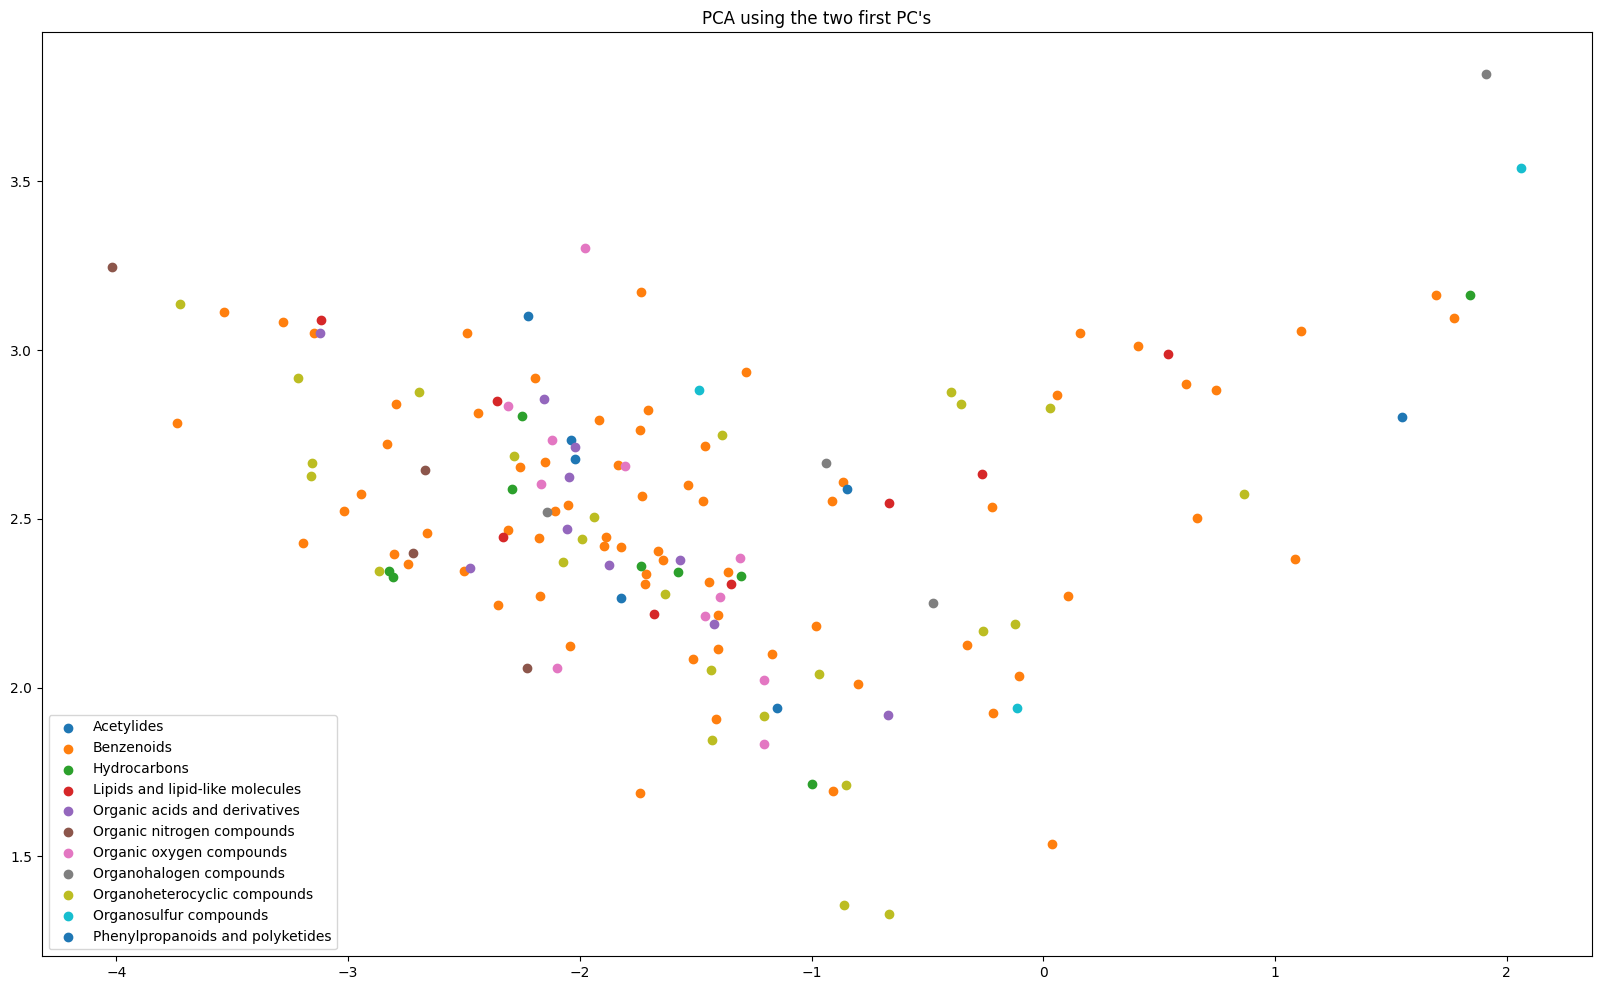

In [2]:
import numpy as np
import torch
labels = np.load('labels.npy')
smiles_ind = np.load('ind_smi.npy')
lats = torch.load('latent.pt')

from grape.plots import pca_2d_plot
ax = pca_2d_plot(latents=lats[smiles_ind], labels=labels, save_fig=True, fig_size=(20,12))

in here


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not array(['Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds', 'Organic compounds',
       'Organic compounds', 'Organic compounds'], dtype='<U17')

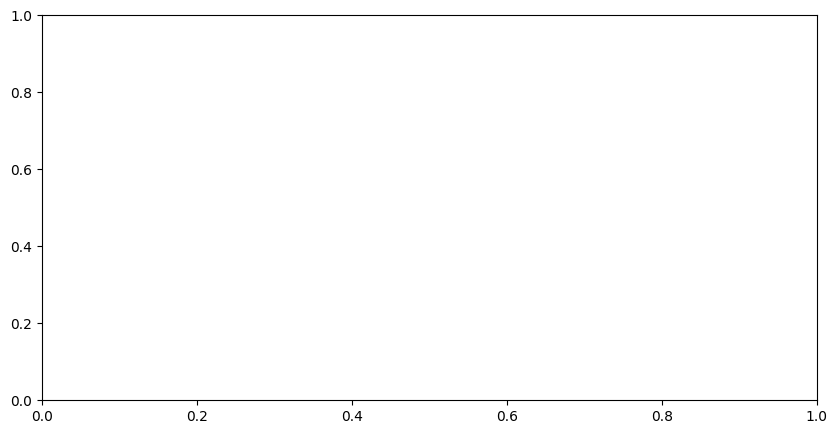

In [1]:
from grape.datasets import BradleyDoublePlus
from grape.splits import taylor_butina_clustering, butina_realistic_splits, butina_train_val_test_splits
data = BradleyDoublePlus()
# print(butina_realistic_splits(data.smiles, [0.8, 0.1, 0.1]))
train, val, test = butina_train_val_test_splits(data.smiles)
print(len(train))
print(len(val))
print(len(test))



{0: (1811, 57, 59, 60, 63, 73, 82, 109, 115, 116, 117, 121, 124, 129, 130, 135, 144, 145, 179, 201, 202, 203, 228, 234, 248, 262, 276, 278, 288, 318, 322, 326, 329, 335, 336, 386, 390, 400, 401, 410, 416, 418, 428, 430, 432, 434, 436, 439, 451, 455, 471, 473, 477, 480, 486, 502, 506, 507, 508, 515, 520, 522, 525, 526, 530, 533, 537, 543, 561, 571, 586, 587, 597, 599, 600, 601, 603, 609, 616, 622, 624, 629, 630, 632, 638, 645, 656, 660, 674, 678, 680, 687, 694, 701, 706, 709, 711, 712, 714, 721, 728, 743, 744, 761, 771, 776, 778, 789, 793, 799, 813, 820, 821, 836, 838, 845, 851, 861, 867, 868, 869, 893, 912, 913, 917, 922, 925, 934, 945, 957, 958, 959, 969, 971, 981, 987, 991, 992, 993, 994, 995, 996, 1000, 1001, 1016, 1024, 1030, 1032, 1033, 1035, 1039, 1043, 1046, 1047, 1055, 1058, 1061, 1065, 1079, 1082, 1083, 1084, 1087, 1093, 1097, 1099, 1114, 1115, 1116, 1118, 1120, 1121, 1123, 1124, 1125, 1127, 1129, 1131, 1136, 1139, 1140, 1143, 1144, 1145, 1146, 1154, 1155, 1158, 1159, 1162, 11